In [1]:
# import all modules here
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.integrate import solve_ivp
from scipy.integrate import simpson
from scipy.special import jv # bessel function of the first kind
import seaborn as sns
sns.set()
sns.set_style("white")

%load_ext autoreload
%autoreload 2
import floquet as fl

In [2]:
# define all variables
s0 = np.array([[1,0],[0,1]])
s1 = np.array([[0,1],[1,0]])
s2 = np.array([[0,-1j],[1j,0]])
s3 = np.array([[1,0],[0,-1]])

# hbar is a global variable
hbar = 0.6582119569 # ev * fs

# these are parameters
v = 3.6/hbar # Ang/fs
Omega = 0.12/hbar # fs^-1
Tpump = 106.16 # fs
Tprobe = 26 # fs
eE0 = 7.5e-3 # eV / Ang
mu = 0.3 # eV
wf = mu/hbar # fs^-1

In [3]:
# function that diagonalizes Ephi=H0phi for IC of Dirac ODE
def Hdirac(kx,ky,v,mu):
    H = hbar*v*kx*s2 - hbar*v*ky*s1 - mu*s0
    return H

def InitialConditions(kx,ky,v,mu):
    """
    Returns phi and E for the time-independent Hamiltonian
    phi[:,alpha] is the alpha'th eigenvector
    """
    # initial Hamiltonian
    hk = Hdirac(kx,ky,v,mu)
    
    # diagonalize it
    E, phi = np.linalg.eigh(hk)
    
    return E, phi

In [4]:
# function f in dt{psi} = f(t,psi)
def dirac(t,psi,kx,ky,v,mu,eE0,Omega,Tpump):
    # add peierls momentum
    kx_bump = -eE0/Omega * np.exp(-t**2/(2*Tpump**2)) * np.cos(Omega*t) / hbar # important to divide by hbar since
    # sub is hbar*k -> eA
    # get H
    H = Hdirac(kx+kx_bump,ky,v,mu)
    # return schrodinger
    f = -1j/hbar * H @ psi
    return f

In [5]:
# enveloppe and fermi functions. 
# the latter is functionally irrelevant as we consider low T
def Enveloppe(t,t0,Tprobe):
    """
    Probe pulse enveloppe function
    """
    return np.exp(-(t-t0)**2/(2*Tprobe**2))

def Fermi(E,kT):
    """
    Fermi distribution
    """
    if kT==0:
        return np.heaviside(-E,0.5)
    else:
        f = 1/(np.exp(E/kT) + 1)
    return f

# Plots vs. $\omega$

In [6]:
# workhorses

# integrates s(t,t0)*e^{iwt}*psi_{alpha,s}(t) and modulus squared
# this is the heart of the program
def PhotocurrentSA(psi,s,kx,ky,w,t0,v,mu,eE0,Omega,Tpump,Tprobe):
    # t-space
    t_space = psi.t
    # integrand: enveloppe * phase * psi
    integrand = Enveloppe(t_space,t0,Tprobe) * np.exp(1j*w*t_space) * psi.y[s,:]
    # integrate samples data using simpson's rule
    I = simpson(integrand,x=t_space)
    return np.abs(I)**2

# main function
def Photocurrent(psi_plus,psi_minus,kx,ky,Es,w,t0,v,mu,eE0,Omega,Tpump,Tprobe):
    """
    Main photocurrent function
    Es[i] corresponds to the energy of the minus (i=0) or plus (i=1) psi
    """
    # the phis are solved for in the main looping function (30/01/23 change)
    
    # integrate and add it up
    P = 0
    for s in range(2):
        # add up both spins
        P += Fermi(Es[0],kT=0) * PhotocurrentSA(psi_minus,s=s,kx=kx,ky=ky,w=w,t0=t0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe) 
        P += Fermi(Es[1],kT=0) * PhotocurrentSA(psi_plus,s=s,kx=kx,ky=ky,w=w,t0=t0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)
    return P

# function to help plotting and making arrays to visualize
def PhotocurrentArrayEnergy(res_w,kx,ky,t0,v,mu,eE0,Omega,Tpump,Tprobe):
    """
    Makes an array in w 
    """
    # set initial parameters
    ws = np.linspace(-np.pi,np.pi,res_w)*Omega - mu/hbar # from inverting (w-wF)/Omega
    
    # diagonalize the time-independent system (at t-> -\infty)
    Es, phis = InitialConditions(kx,ky,v,mu)

    # solve the dirac equation
    psi_plus = solve_ivp(fun=dirac, t_span=[-600,500], y0=phis[:,1], args=(kx,ky,v,mu,eE0,Omega,Tpump), method='RK45')
    psi_minus = solve_ivp(fun=dirac, t_span=[-600,500], y0=phis[:,0], args=(kx,ky,v,mu,eE0,Omega,Tpump), method='RK45')

    P = np.zeros(res_w, dtype=float)
    for i,w in enumerate(ws):
        P[i] = Photocurrent(psi_plus=psi_plus,psi_minus=psi_minus,Es=Es,kx=kx,ky=ky,w=w,t0=t0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)
            
    return ws, P

In [7]:
ws5, Ps5 = PhotocurrentArrayEnergy(res_w=100,kx=0.05,ky=0,t0=-500,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)
ws1, Ps1 = PhotocurrentArrayEnergy(res_w=100,kx=0.05,ky=0,t0=-100,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)
ws0, Ps0 = PhotocurrentArrayEnergy(res_w=100,kx=0.05,ky=0,t0=0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)

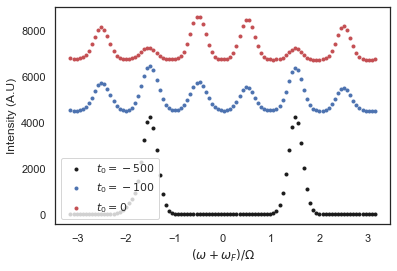

In [8]:
# plot it
plt.figure()

plt.scatter((ws5+wf)/Omega,Ps5,c='k',marker='.',label=r"$t_0 = -500$")

shift1 = np.max(Ps5) + 250

plt.scatter((ws1+wf)/Omega,Ps1+shift1,c='b',marker='.',label=r"$t_0 = -100$")

shift2 = shift1 + np.max(Ps1) + 250

plt.scatter((ws0+wf)/Omega,Ps0+shift2,c='r',marker='.',label=r"$t_0 = 0$")
plt.legend()
plt.xlabel(r"$\left(\omega+\omega_F\right)/\Omega$")
plt.ylabel(r"Intensity (A.U)")
plt.show()

In [126]:
# at kx=0
ws5_0, Ps5_0 = PhotocurrentArrayEnergy(res_w=100,kx=0.0,ky=0,t0=-500,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)
ws1_0, Ps1_0 = PhotocurrentArrayEnergy(res_w=100,kx=0.0,ky=0,t0=-100,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)
ws0_0, Ps0_0 = PhotocurrentArrayEnergy(res_w=100,kx=0.0,ky=0,t0=0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)

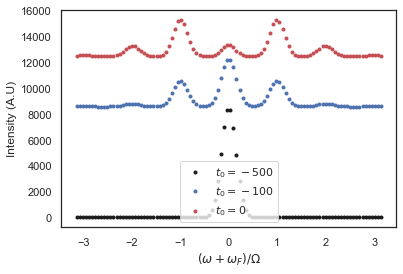

In [127]:
# plot it
plt.figure()

plt.scatter((ws5_0+wf)/Omega,Ps5_0,c='k',marker='.',label=r"$t_0 = -500$")

shift1 = np.max(Ps5_0) + 250

plt.scatter((ws1_0+wf)/Omega,Ps1_0+shift1,c='b',marker='.',label=r"$t_0 = -100$")

shift2 = shift1 + np.max(Ps1_0) + 250

plt.scatter((ws0_0+wf)/Omega,Ps0_0+shift2,c='r',marker='.',label=r"$t_0 = 0$")
plt.legend()
plt.xlabel(r"$\left(\omega+\omega_F\right)/\Omega$")
plt.ylabel(r"Intensity (A.U)")
plt.show()

In [130]:
# compare these results to the analytic ones

# analytic expression for photocurrent
def PhotocurrentAnalytic(kx,ky,w,t0,v,mu,eE0,Omega,Tpump,Tprobe):
    """
    Analytic expression for photocurrent
    """
    # compute energies
    Es, phi = InitialConditions(kx=kx,ky=ky,v=v,mu=mu)
    
    # compute Aeff
    # Aeff = eE0*v/(Omega**2 * 2*np.sqrt(2*np.pi)) * Tpump/Tprobe * np.exp(-t0**2/(2*(Tprobe**2+Tpump**2))) / np.sqrt(Tprobe**2 + Tpump**2)
    Aeff = eE0*v/(hbar*Omega**2) * np.exp(-t0**2/(2*Tpump**2))
    
    # sum over alpha
    I = 0
    for i, a in enumerate([-1,1]):
        f = Fermi(Es[i],kT=1e-4)
        # sum over bessel functions m
        for m in range(-10,10):
            J2E = jv(m,a*Aeff)**2 * np.exp(-(w - a*v*kx + mu/hbar - m*Omega)**2 * Tprobe**2)
            I += f * J2E
            
    I *= 2*np.pi*Tprobe**2
            
    return I

# function to make array
def PhotocurrentAnalyticArray(kx,ky,t0,v,mu,eE0,Omega,Tpump,Tprobe):
    """
    Makes an array to plot I vs. w
    """
    res = 100
    ws = np.linspace(-np.pi,np.pi,res)*Omega - mu/hbar # from inverting (w+wF)/Omega

    P = np.zeros(res,dtype=float)
    for i in range(res):
        w = ws[i]
        P[i] = PhotocurrentAnalytic(kx=kx,ky=ky,w=w,t0=t0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)
            
    return ws, P

In [131]:
# run it 
ws0_ana,Ps0_ana=PhotocurrentAnalyticArray(kx=0.05,ky=0,t0=0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)
ws1_ana,Ps1_ana=PhotocurrentAnalyticArray(kx=0.05,ky=0,t0=-100,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)
ws5_ana,Ps5_ana=PhotocurrentAnalyticArray(kx=0.05,ky=0,t0=-500,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)

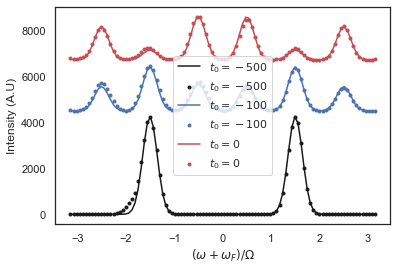

In [132]:
# plot them over
plt.figure()

plt.plot((ws5_ana+wf)/Omega,Ps5_ana,c='k',label=r"$t_0 = -500$")
plt.scatter((ws5+wf)/Omega,Ps5,c='k',marker='.',label=r"$t_0 = -500$")

shift1 = np.max(Ps5) + 250

plt.plot((ws1_ana+wf)/Omega,Ps1_ana + shift1,c='b',label=r"$t_0 = -100$")
plt.scatter((ws1+wf)/Omega,Ps1 + shift1,c='b',marker='.',label=r"$t_0 = -100$")

shift2 = shift1 + np.max(Ps1) + 250

plt.plot((ws0_ana+wf)/Omega,Ps0_ana + shift2,c='r',label=r"$t_0 = 0$")
plt.scatter((ws0+wf)/Omega,Ps0 + shift2,c='r',marker='.',label=r"$t_0 = 0$")

plt.legend()
plt.xlabel(r"$\left(\omega+\omega_F\right)/\Omega$")
plt.ylabel(r"Intensity (A.U)")
plt.show()

In [133]:
ws0_ana_0,Ps0_ana_0=PhotocurrentAnalyticArray(kx=0.0,ky=0,t0=0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)
ws1_ana_0,Ps1_ana_0=PhotocurrentAnalyticArray(kx=0.0,ky=0,t0=-100,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)
ws5_ana_0,Ps5_ana_0=PhotocurrentAnalyticArray(kx=0.0,ky=0,t0=-500,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)

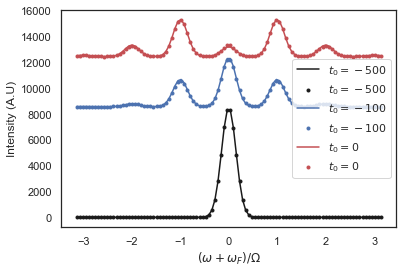

In [134]:
# plot them over
plt.figure()

plt.plot((ws5_ana_0+wf)/Omega,Ps5_ana_0,c='k',label=r"$t_0 = -500$")
plt.scatter((ws5_0+wf)/Omega,Ps5_0,c='k',marker='.',label=r"$t_0 = -500$")

shift1 = np.max(Ps5_0) + 250

plt.plot((ws1_ana_0+wf)/Omega,Ps1_ana_0 + shift1,c='b',label=r"$t_0 = -100$")
plt.scatter((ws1_0+wf)/Omega,Ps1_0 + shift1,c='b',marker='.',label=r"$t_0 = -100$")

shift2 = shift1 + np.max(Ps1_0) + 250

plt.plot((ws0_ana_0+wf)/Omega,Ps0_ana_0 + shift2,c='r',label=r"$t_0 = 0$")
plt.scatter((ws0_0+wf)/Omega,Ps0_0 + shift2,c='r',marker='.',label=r"$t_0 = 0$")

plt.legend()
plt.xlabel(r"$\left(\omega+\omega_F\right)/\Omega$")
plt.ylabel(r"Intensity (A.U)")
plt.show()

# Plot in $k_x$ vs. $\omega$

In [22]:
# tool to help plot labels in the right places
def coord_to_res(x,x_up,x_low,res):
    """
    translates physical value (kx = 0) to pixel (res/2)
    linear scaling compatible only
    """
    m = (res-1)/(x_up-x_low)
    b = -m * x_low
    return m*x+b

In [23]:
def PhotocurrentArrayWK(k_dir,k_other,t0,v,mu,eE0,Omega,Tpump,Tprobe):
    """
    Makes an array in k-w plane 
    k_dir==1 for x and 2 for y
    k_other is the value of the remaining momentum
    """
    # set initial parameters
    res = 100
    res_k = res
    res_w = res
    
    # make arrays
    ks = np.linspace(-0.1,0.1,res_k)
    P = np.zeros((res_k,res_w), dtype=float)
    
    # loop over k
    if k_dir == 1:
        for i,kx in enumerate(ks):
            P[i,:] = PhotocurrentArrayEnergy(res_w=res_w,kx=kx,ky=k_other,t0=t0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)[1] # second component is ps
            
    elif k_dir == 2:
        for i,ky in enumerate(ks):
            P[i,:] = PhotocurrentArrayEnergy(res_w=res_w,kx=k_other,ky=ky,t0=t0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)[1] # second component is ps
        
    return P

In [24]:
P = PhotocurrentArrayWK(k_dir=1,k_other=0,t0=0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)


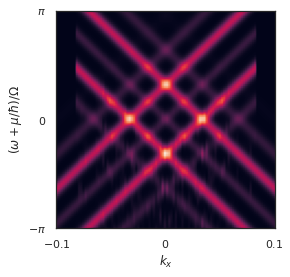

In [25]:
plt.imshow(P.T)
plt.ylim(0,99)
plt.xticks(coord_to_res(np.asarray([-0.1,0.0,0.1]),x_up=0.1,x_low=-0.1,res=100),labels=[r"$-0.1$",r"$0$",r"$0.1$"])
plt.yticks(coord_to_res(np.asarray([-np.pi,0.,np.pi]),x_up=np.pi,x_low=-np.pi,res=100),labels=[r"$-\pi$",r"$0$",r"$\pi$"])
plt.ylabel(r"$(\omega + \mu/\hbar)/\Omega$")
plt.xlabel(r"$k_x$")
plt.show()

In [140]:
P = PhotocurrentArrayWK(ky=0,t0=-100,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)


done 0
done 1
done 2
done 3
done 4
done 5
done 6
done 7
done 8
done 9
done 10
done 11
done 12
done 13
done 14
done 15
done 16
done 17
done 18
done 19
done 20
done 21
done 22
done 23
done 24
done 25
done 26
done 27
done 28
done 29
done 30
done 31
done 32
done 33
done 34
done 35
done 36
done 37
done 38
done 39
done 40
done 41
done 42
done 43
done 44
done 45
done 46
done 47
done 48
done 49
done 50
done 51
done 52
done 53
done 54
done 55
done 56
done 57
done 58
done 59
done 60
done 61
done 62
done 63
done 64
done 65
done 66
done 67
done 68
done 69
done 70
done 71
done 72
done 73
done 74
done 75
done 76
done 77
done 78
done 79
done 80
done 81
done 82
done 83
done 84
done 85
done 86
done 87
done 88
done 89
done 90
done 91
done 92
done 93
done 94
done 95
done 96
done 97
done 98
done 99


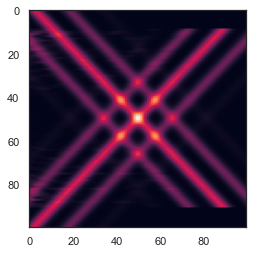

In [141]:
plt.imshow(P)

In [135]:
P = PhotocurrentArrayWK(ky=0,t0=-500,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)


done 0
done 1
done 2
done 3
done 4
done 5
done 6
done 7
done 8
done 9
done 10
done 11
done 12
done 13
done 14
done 15
done 16
done 17
done 18
done 19
done 20
done 21
done 22
done 23
done 24
done 25
done 26
done 27
done 28
done 29
done 30
done 31
done 32
done 33
done 34
done 35
done 36
done 37
done 38
done 39
done 40
done 41
done 42
done 43
done 44
done 45
done 46
done 47
done 48
done 49
done 50
done 51
done 52
done 53
done 54
done 55
done 56
done 57
done 58
done 59
done 60
done 61
done 62
done 63
done 64
done 65
done 66
done 67
done 68
done 69
done 70
done 71
done 72
done 73
done 74
done 75
done 76
done 77
done 78
done 79
done 80
done 81
done 82
done 83
done 84
done 85
done 86
done 87
done 88
done 89
done 90
done 91
done 92
done 93
done 94
done 95
done 96
done 97
done 98
done 99


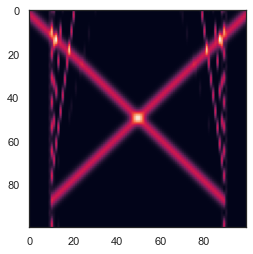

In [136]:
plt.imshow(P.T)

# Plot in $k_y$ vs. $\omega$

In [150]:
P = PhotocurrentArrayWK(k_dir=2,k_other=0,t0=-500,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)


done 0
done 1
done 2
done 3
done 4
done 5
done 6
done 7
done 8
done 9
done 10
done 11
done 12
done 13
done 14
done 15
done 16
done 17
done 18
done 19
done 20
done 21
done 22
done 23
done 24
done 25
done 26
done 27
done 28
done 29
done 30
done 31
done 32
done 33
done 34
done 35
done 36
done 37
done 38
done 39
done 40
done 41
done 42
done 43
done 44
done 45
done 46
done 47
done 48
done 49
done 50
done 51
done 52
done 53
done 54
done 55
done 56
done 57
done 58
done 59
done 60
done 61
done 62
done 63
done 64
done 65
done 66
done 67
done 68
done 69
done 70
done 71
done 72
done 73
done 74
done 75
done 76
done 77
done 78
done 79
done 80
done 81
done 82
done 83
done 84
done 85
done 86
done 87
done 88
done 89
done 90
done 91
done 92
done 93
done 94
done 95
done 96
done 97
done 98
done 99


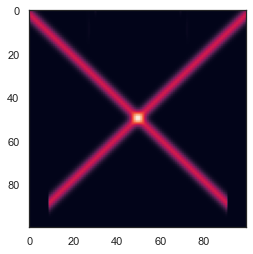

In [151]:
plt.imshow(P.T)

In [146]:
P = PhotocurrentArrayWK(k_dir=2,k_other=0,t0=-100,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)


done 0
done 1
done 2
done 3
done 4
done 5
done 6
done 7
done 8
done 9
done 10
done 11
done 12
done 13
done 14
done 15
done 16
done 17
done 18
done 19
done 20
done 21
done 22
done 23
done 24
done 25
done 26
done 27
done 28
done 29
done 30
done 31
done 32
done 33
done 34
done 35
done 36
done 37
done 38
done 39
done 40
done 41
done 42
done 43
done 44
done 45
done 46
done 47
done 48
done 49
done 50
done 51
done 52
done 53
done 54
done 55
done 56
done 57
done 58
done 59
done 60
done 61
done 62
done 63
done 64
done 65
done 66
done 67
done 68
done 69
done 70
done 71
done 72
done 73
done 74
done 75
done 76
done 77
done 78
done 79
done 80
done 81
done 82
done 83
done 84
done 85
done 86
done 87
done 88
done 89
done 90
done 91
done 92
done 93
done 94
done 95
done 96
done 97
done 98
done 99


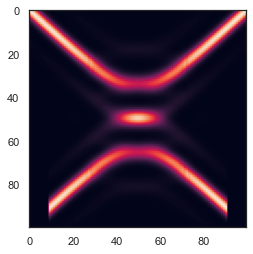

In [148]:
plt.imshow(P.T)

In [152]:
P = PhotocurrentArrayWK(k_dir=2,k_other=0,t0=0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)


done 0
done 1
done 2
done 3
done 4
done 5
done 6
done 7
done 8
done 9
done 10
done 11
done 12
done 13
done 14
done 15
done 16
done 17
done 18
done 19
done 20
done 21
done 22
done 23
done 24
done 25
done 26
done 27
done 28
done 29
done 30
done 31
done 32
done 33
done 34
done 35
done 36
done 37
done 38
done 39
done 40
done 41
done 42
done 43
done 44
done 45
done 46
done 47
done 48
done 49
done 50
done 51
done 52
done 53
done 54
done 55
done 56
done 57
done 58
done 59
done 60
done 61
done 62
done 63
done 64
done 65
done 66
done 67
done 68
done 69
done 70
done 71
done 72
done 73
done 74
done 75
done 76
done 77
done 78
done 79
done 80
done 81
done 82
done 83
done 84
done 85
done 86
done 87
done 88
done 89
done 90
done 91
done 92
done 93
done 94
done 95
done 96
done 97
done 98
done 99


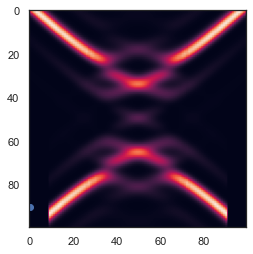

In [156]:
plt.imshow(P.T)
plt.scatter(0,90)

# Circularly polarized light

We now want to look at circularly polarized light. This only changes the Dirac equation -- the rest stays the same.

In [9]:
# function f in dt{psi} = f(t,psi)
def dirac_circular(t,psi,kx,ky,v,mu,eE0,Omega,Tpump):
    # kinetic energy part
    K = hbar*v*kx*s2 - hbar*v*ky*s1 - mu*s0
    # floquet pump part
    A = -v * eE0/Omega * np.exp(-t**2/(2*Tpump**2)) * (np.cos(Omega*t) * s2 - np.sin(Omega*t) * s1)
    # hamiltonian
    H = K + A 
    # TDSE d psi / dt = (below)
    f = -1j/hbar * H @ psi
    return f

# function to help plotting and making arrays to visualize
def PhotocurrentArrayEnergyCircular(res_w,wp_bounds,kx,ky,t0,v,mu,eE0,Omega,Tpump,Tprobe):
    """
    Makes an array in w 
    """
    # set initial parameters
    ws = np.linspace(wp_bounds[0],wp_bounds[1],res_w)*Omega - mu/hbar # from inverting (w+wF)/Omega
    # note that the input bounds are on the normalized frequency wp = (w+wf)/Omega
    
    # diagonalize the time-independent system (at t-> -\infty)
    Es, phis = InitialConditions(kx,ky,v,mu)

    # solve the dirac equation
    psi_plus = solve_ivp(fun=dirac_circular, t_span=[-600,500], y0=phis[:,1], args=(kx,ky,v,mu,eE0,Omega,Tpump), method='RK45')
    psi_minus = solve_ivp(fun=dirac_circular, t_span=[-600,500], y0=phis[:,0], args=(kx,ky,v,mu,eE0,Omega,Tpump), method='RK45')

    P = np.zeros(res_w, dtype=float)
    for i,w in enumerate(ws):
        P[i] = Photocurrent(psi_plus=psi_plus,psi_minus=psi_minus,Es=Es,kx=kx,ky=ky,w=w,t0=t0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)
            
    return ws, P

In [19]:
ws5, Ps5 = fl.PhotocurrentArrayEnergyCircular(res_w=100,wp_bounds=[-3,3],kx=0.0,ky=0,t0=-500,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)
ws1, Ps1 = fl.PhotocurrentArrayEnergyCircular(res_w=100,wp_bounds=[-3,3],kx=0.0,ky=0,t0=-100,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)
ws0, Ps0 = fl.PhotocurrentArrayEnergyCircular(res_w=100,wp_bounds=[-3,3],kx=0.0,ky=0,t0=0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)

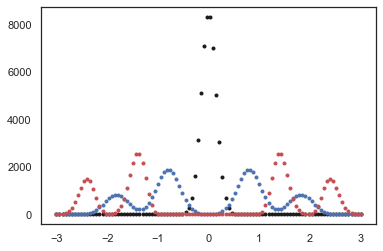

In [20]:
plt.scatter((ws5+wf)/Omega,Ps5,c='k',marker='.',label=r"$t_0 = -500$")
plt.scatter((ws1+wf)/Omega,Ps1,c='b',marker='.',label=r"$t_0 = -100$")
plt.scatter((ws0+wf)/Omega,Ps0,c='r',marker='.',label=r"$t_0 = 0$")

In [12]:
def PhotocurrentArrayWKCircular(k_dir,k_other,k_bounds,wp_bounds,t0,v,mu,eE0,Omega,Tpump,Tprobe):
    """
    Makes an array in k-w plane 
    k_dir==1 for x and 2 for y
    k_other is the value of the remaining momentum
    """
    # set initial parameters
    res = 100 # takes ~30 seconds
    res_k = res
    res_w = res
    
    # make arrays
    ks = np.linspace(k_bounds[0],k_bounds[1],res_k)
    P = np.zeros((res_k,res_w), dtype=float)
    
    # loop over k
    if k_dir == 1:
        for i,kx in enumerate(ks):
            P[i,:] = PhotocurrentArrayEnergyCircular(res_w=res_w,wp_bounds=wp_bounds,kx=kx,ky=k_other,t0=t0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)[1] # second component is ps
            
    elif k_dir == 2:
        for i,ky in enumerate(ks):
            P[i,:] = PhotocurrentArrayEnergyCircular(res_w=res_w,wp_bounds=wp_bounds,kx=k_other,ky=ky,t0=t0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)[1] # second component is ps
        
    return P

In [13]:
P = PhotocurrentArrayWKCircular(k_dir=1,k_other=0,k_bounds=[-0.1,0.1],wp_bounds=[-np.pi,np.pi],t0=0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)
# P_zoom = PhotocurrentArrayWKCircular(k_dir=1,k_other=0,k_bounds=[0,0.1],wp_bounds=[-np.pi,0],t0=0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)


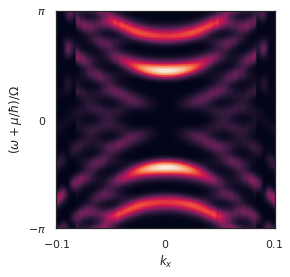

In [19]:
plt.imshow(P.T)
plt.ylim([0,99])
plt.xticks(coord_to_res(np.asarray([-0.1,0.0,0.1]),x_up=0.1,x_low=-0.1,res=100),labels=[r"$-0.1$",r"$0$",r"$0.1$"])
plt.yticks(coord_to_res(np.asarray([-np.pi,0.,np.pi]),x_up=np.pi,x_low=-np.pi,res=100),labels=[r"$-\pi$",r"$0$",r"$\pi$"])
plt.ylabel(r"$(\omega + \mu/\hbar)/\Omega$")
plt.xlabel(r"$k_x$")
# w=O
# plt.axhline(coord_to_res(1/2,x_up=np.pi,x_low=-np.pi,res=100))
# plt.axvline(coord_to_res(Omega/(2*v),x_up=0.1,x_low=-0.1,res=100))
# plt.scatter(coord_to_res(ks,x_up=0.1,x_low=-0.1,res=100),coord_to_res((1+gap)/2+mu/hbar,x_up=np.pi,x_low=-np.pi,res=100))

plt.show()

# plt.imshow(P_zoom.T)
# plt.ylim([0,99])
# plt.xlim([0,99])
# plt.xticks(coord_to_res(np.asarray([0,0.05,0.1]),x_up=0.1,x_low=0,res=100),labels=[r"$0$",r"$0.05$",r"$0.1$"])
# plt.yticks(coord_to_res(np.asarray([-np.pi,0.]),x_up=0.,x_low=-np.pi,res=100),labels=[r"$-\pi$",r"$0$"])

# plt.show()

In [20]:
P_zoomzoom = PhotocurrentArrayWKCircular(k_dir=1,k_other=0,k_bounds=[0.05,0.1],wp_bounds=[-np.pi,-np.pi/2],t0=0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)


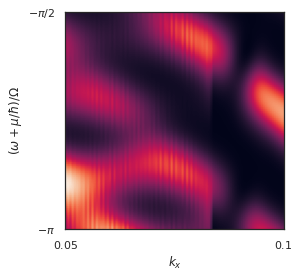

In [21]:
plt.imshow(P_zoomzoom.T)
plt.ylim([0,99])
plt.xticks(coord_to_res(np.asarray([0.05,0.1]),x_up=0.1,x_low=0.05,res=100),labels=[r"$0.05$",r"$0.1$"])
plt.yticks(coord_to_res(np.asarray([-np.pi,-np.pi/2]),x_up=-np.pi/2,x_low=-np.pi,res=100),labels=[r"$-\pi$",r"$-\pi/2$"])
plt.ylabel(r"$(\omega + \mu/\hbar)/\Omega$")
plt.xlabel(r"$k_x$")

plt.show()

In [262]:
P_tami = PhotocurrentArrayWKCircular(k_dir=1,k_other=0,k_bounds=[0.05,0.1],wp_bounds=[-np.pi,-np.pi/2],t0=0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)


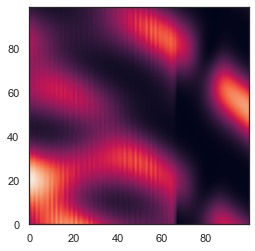

In [263]:
plt.imshow(P_tami.T)
plt.ylim([0,99])
# plt.xticks(coord_to_res(np.asarray([0.05,0.1]),x_up=0.1,x_low=0.05,res=100),labels=[r"$0.05$",r"$0.1$"])
# plt.yticks(coord_to_res(np.asarray([-np.pi,-np.pi/2]),x_up=-np.pi/2,x_low=-np.pi,res=100),labels=[r"$-\pi$",r"$-\pi/2$"])

# plt.axhline(coord_to_res(1/2-mu/(hbar*Omega),x_up=-np.pi/2,x_low=-np.pi,res=100))

plt.show()

# Comparison to analytics
Compare these results to the gap we expect to find analytically.

Small $eE0 \sim 10^{-3}$

In [636]:
efield = 0.0015
wp_up = 1
wp_down = -0
k_up = 0.05
k_down = -0.05
P_ana = PhotocurrentArrayWKCircular(k_dir=1,k_other=0,k_bounds=[k_down,k_up],wp_bounds=[wp_down,wp_up],t0=0,v=v,mu=mu,eE0=efield,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)


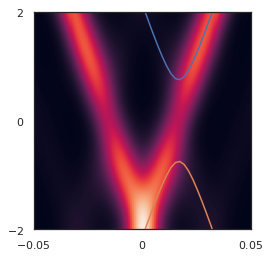

In [638]:
plt.figure()
plt.imshow(P_ana.T)
plt.ylim([0,99])
plt.xlim([0,99])
plt.xticks(coord_to_res(np.asarray([-0.1,0.0,0.1]),x_up=0.1,x_low=-0.1,res=100),labels=[r"$-0.05$",r"$0$",r"$0.05$"])
plt.yticks(coord_to_res(np.asarray([-2,0.,2]),x_up=2,x_low=-2,res=100),labels=[r"$-2$",r"$0$",r"$2$"])

ks_ana = np.linspace(-0.1,0.1,100)
k0 = Omega/(2*v)
eta = efield*v/(hbar*Omega**2)
gap = np.sqrt((1-ks_ana/k0)**2 + eta**2) # assuming kx>0 and ky=0
ep = 1/2*(1+gap)
em = 1/2*(1-gap)

plt.plot(coord_to_res(ks_ana,x_up=k_up,x_low=k_down,res=100),coord_to_res(ep,x_up=wp_up,x_low=wp_down,res=100))
plt.plot(coord_to_res(ks_ana,x_up=k_up,x_low=k_down,res=100),coord_to_res(em,x_up=wp_up,x_low=wp_down,res=100))

plt.show()

In [10]:
def Hfloquet(kx,ky,m,efield):
    """
    analytic floquet hamiltonian
    """
    # diagonals are bare H + hbar*m*Omega
    # goes from -m to m-1 inclusive
    diags_flat = np.asarray([hbar*v*(kx*s2-ky*s1) - em*hbar*Omega*s0 - mu*s0 for em in range(-m,m)])
    diags = scipy.linalg.block_diag(*diags_flat)
    
    # off-diagonals due to Apump
    offdiag_top = -1j*efield*v/(2*Omega) * np.kron(np.eye(2*m,k=+1),s1-1j*s2)
    offdiag_bot = offdiag_top.conj().T
    
    H = diags + offdiag_bot + offdiag_top
    
    return H

def FloquetEnergies(ky,m,efield):
    res=100
    Es = np.zeros((4*m*res),dtype=float)
    kxs_ret = np.zeros((4*m*res))
    
    kxs = np.linspace(-0.1,0.1,res)
    
    for i,kx in enumerate(kxs):
        H = Hfloquet(kx,ky,m,efield)
        E = np.linalg.eigvalsh(H)
        Es[i*4*m:(i+1)*4*m] = E
        kxs_ret[i*4*m:(i+1)*4*m] = np.full(4*m,kx)
        
    return kxs_ret, Es

In [586]:
ks,es=FloquetEnergies(ky=0,m=10)

In [626]:
%matplotlib inline

from ipywidgets import interact

@interact(efield=(0,0.01,0.0001))
def interactiveplot(efield):
    ks,es=FloquetEnergies(ky=0,m=10,efield=efield)
    plt.scatter(ks,(es+mu)/(hbar*Omega),c='k',marker='.')
    plt.ylim(-2,2)
    ks_ana = np.linspace(-0.1,0.1,100)
    k0 = Omega/(2*v)
    eta = efield*v/(hbar*Omega**2)
    gap = np.sqrt((1-ks_ana/k0)**2 + eta**2) # assuming kx>0 and ky=0

    plt.axvline(Omega/(2*v))
    plt.plot(ks_ana,1/2*(1+gap))
    plt.plot(ks_ana,1/2*(1-gap))


    plt.show()

interactive(children=(FloatSlider(value=0.005, description='efield', max=0.01, step=0.0001), Output()), _dom_c…

Put this bandstructure on top of the Photocurrent even for large $E_0$.

In [18]:
# numerical photocurrent results
P_match = PhotocurrentArrayWKCircular(k_dir=1,k_other=0,k_bounds=[0.,0.1],wp_bounds=[-3,0],t0=0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)


In [13]:
# numerical floquet bandstructure
ks_match,es_match=FloquetEnergies(ky=0,m=10,efield=eE0)
wp_match = (es_match/hbar+mu/hbar)/Omega

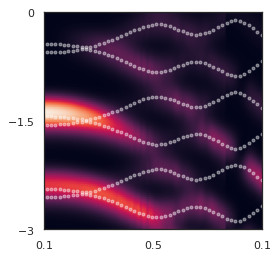

In [24]:
plt.figure()
plt.imshow(P_match.T)
plt.ylim([0,99])
plt.xlim([0,99])
plt.xticks(coord_to_res(np.asarray([-0.1,0.0,0.1]),x_up=0.1,x_low=-0.1,res=100),labels=[r"$0.1$",r"$0.5$",r"$0.1$"])
plt.yticks(coord_to_res(np.asarray([-3,0.,3]),x_up=3,x_low=-3,res=100),labels=[r"$-3$",r"$-1.5$",r"$0$"])

plt.scatter(coord_to_res(ks_match,x_up=0.1,x_low=-0.,res=100),coord_to_res(wp_match,x_up=3,x_low=0,res=100),
           c='white',marker='.',alpha=0.4)

plt.show()

# Varying $T$

First, $T_{pump}$ then $T_{probe}$.

In [25]:
Tpump_big = Tpump*10
Tpump_small = Tpump/10
P_tpumpbig = fl.PhotocurrentArrayWKCircular(k_dir=1,k_other=0,k_bounds=[-0.1,0.1],wp_bounds=[-np.pi,np.pi],t0=0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump_big,Tprobe=Tprobe)
P_tpumpsmall = fl.PhotocurrentArrayWKCircular(k_dir=1,k_other=0,k_bounds=[-0.1,0.1],wp_bounds=[-np.pi,np.pi],t0=0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump_small,Tprobe=Tprobe)


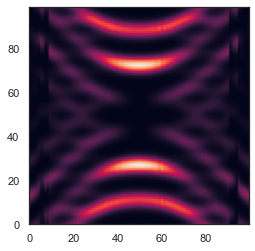

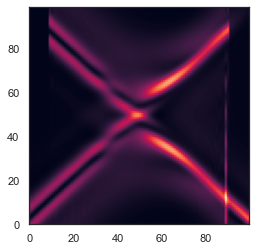

In [28]:
plt.figure()
plt.imshow(P_tpumpbig.T)
plt.ylim([0,99])
plt.show()

plt.figure()
plt.imshow(P_tpumpsmall.T)
plt.ylim([0,99])
plt.show()

In [121]:
Tprobe_big = Tprobe*10
Tprobe_small = Tprobe/10
P_tprobebig = fl.PhotocurrentArrayWKCircular(k_dir=1,k_other=0,k_bounds=[-0.1,0.1],wp_bounds=[-np.pi,np.pi],t0=0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe_big)
P_tprobesmall = fl.PhotocurrentArrayWKCircular(k_dir=1,k_other=0,k_bounds=[-0.1,0.1],wp_bounds=[-np.pi,np.pi],t0=0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe_small)


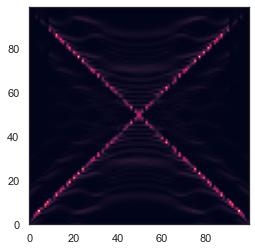

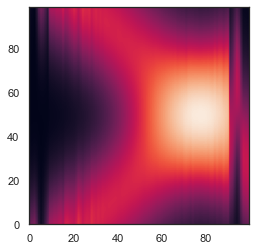

In [122]:
plt.figure()
plt.imshow(P_tprobebig.T)
plt.ylim([0,99])
plt.show()

plt.figure()
plt.imshow(P_tprobesmall.T)
plt.ylim([0,99])
plt.show()

spin-polarized

In [128]:
P_pol = fl.PhotocurrentArrayWKCircular_polarized(sigma=np.array([1,1j]/np.sqrt(2)),k_dir=1,k_other=0,k_bounds=[-0.1,0.1],wp_bounds=[-3,3],t0=-0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)


(0.0, 99.0)

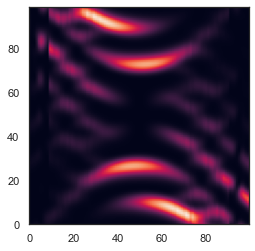

In [129]:
plt.imshow(P_pol.T)
plt.ylim([0,99])

In [125]:
P_pol_tpumpsmall = fl.PhotocurrentArrayWKCircular_polarized(sigma=np.array([1,1j]/np.sqrt(2)),k_dir=1,k_other=0,k_bounds=[-0.1,0.1],wp_bounds=[-3,3],t0=0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump_small,Tprobe=Tprobe)
P_pol_tpumpbig = fl.PhotocurrentArrayWKCircular_polarized(sigma=np.array([1,1j]/np.sqrt(2)),k_dir=1,k_other=0,k_bounds=[-0.1,0.1],wp_bounds=[-3,3],t0=0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump_big,Tprobe=Tprobe)

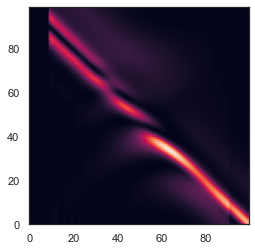

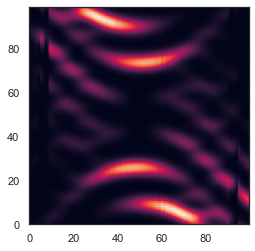

In [127]:
plt.imshow(P_pol_tpumpsmall.T)
plt.ylim([0,99])
plt.show()

plt.imshow(P_pol_tpumpbig.T)
plt.ylim([0,99])
plt.show()

In [148]:
P_pol_tprobesmall = fl.PhotocurrentArrayWKCircular_polarized(sigma=np.array([1,1j]/np.sqrt(2)),k_dir=1,k_other=0,k_bounds=[-0.1,0.1],wp_bounds=[-3,3],t0=0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe_small)
P_pol_tprobebig = fl.PhotocurrentArrayWKCircular_polarized(sigma=np.array([1,1j]/np.sqrt(2)),k_dir=1,k_other=0,k_bounds=[-0.1,0.1],wp_bounds=[-3,3],t0=0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe_big)

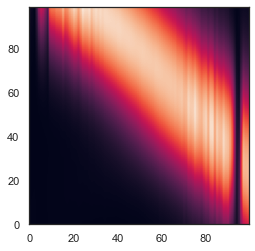

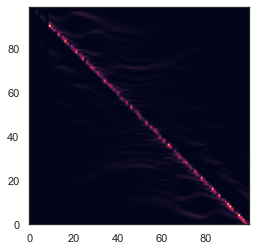

In [149]:
plt.imshow(P_pol_tprobesmall.T)
plt.ylim([0,99])
plt.show()

plt.imshow(P_pol_tprobebig.T)
plt.ylim([0,99])
plt.show()

Vary the polarization to see if the asymmetry persists or changes.

In [130]:
def PhotocurrentArrayEnergyLinear_polarized(sigma,res_w,wp_bounds,kx,ky,t0,v,mu,eE0,Omega,Tpump,Tprobe):
    """
    Makes an array in w 
    """
    # set initial parameters
    ws = np.linspace(wp_bounds[0],wp_bounds[1],res_w)*Omega - mu/hbar # from inverting (w+wF)/Omega
    # note that the input bounds are on the normalized frequency wp = (w+wf)/Omega
    
    # diagonalize the time-independent system (at t-> -\infty)
    Es, phis = InitialConditions(kx,ky,v,mu)

    # solve the dirac equation
    psi_plus = solve_ivp(fun=dirac, t_span=[-600,500], y0=phis[:,1], args=(kx,ky,v,mu,eE0,Omega,Tpump), method='RK45')
    psi_minus = solve_ivp(fun=dirac, t_span=[-600,500], y0=phis[:,0], args=(kx,ky,v,mu,eE0,Omega,Tpump), method='RK45')

    P = np.zeros(res_w, dtype=float)
    for i,w in enumerate(ws):
        P[i] = Photocurrent_polarized(sigma=sigma,psi_plus=psi_plus,psi_minus=psi_minus,Es=Es,kx=kx,ky=ky,w=w,t0=t0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)
            
    return ws, P

def PhotocurrentArrayWKLinear_polarized(sigma,k_dir,k_other,k_bounds,wp_bounds,t0,v,mu,eE0,Omega,Tpump,Tprobe):
    """
    Makes an array in k-w plane 
    k_dir==1 for x and 2 for y
    k_other is the value of the remaining momentum
    """
    # set initial parameters
    res = 100 # takes ~30 seconds
    res_k = res
    res_w = res
    
    # make arrays
    ks = np.linspace(k_bounds[0],k_bounds[1],res_k)
    P = np.zeros((res_k,res_w), dtype=float)
    
    # loop over k
    if k_dir == 1:
        for i,kx in enumerate(ks):
            P[i,:] = PhotocurrentArrayEnergyLinear_polarized(sigma=sigma,res_w=res_w,wp_bounds=wp_bounds,kx=kx,ky=k_other,t0=t0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)[1] # second component is ps
            
    elif k_dir == 2:
        for i,ky in enumerate(ks):
            P[i,:] = PhotocurrentArrayEnergyLinear_polarized(sigma=sigma,res_w=res_w,wp_bounds=wp_bounds,kx=k_other,ky=ky,t0=t0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)[1] # second component is ps
        
    return P

In [131]:
P_pol = PhotocurrentArrayWKLinear_polarized(sigma=np.array([1,1j]/np.sqrt(2)),k_dir=1,k_other=0,k_bounds=[-0.1,0.1],wp_bounds=[-3,3],t0=0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)


(0.0, 99.0)

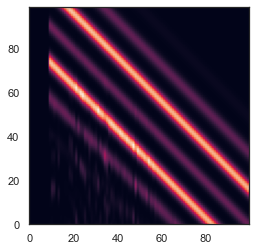

In [132]:
plt.imshow(P_pol.T)
plt.ylim([0,99])

In [133]:
P_pol_tpumpsmall = PhotocurrentArrayWKLinear_polarized(sigma=np.array([1,1j]/np.sqrt(2)),k_dir=1,k_other=0,k_bounds=[-0.1,0.1],wp_bounds=[-3,3],t0=0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump_small,Tprobe=Tprobe)


(0.0, 99.0)

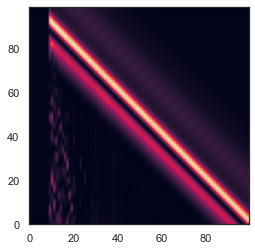

In [134]:
plt.imshow(P_pol_tpumpsmall.T)
plt.ylim([0,99])

In [135]:
P_pol_tpumpbig = PhotocurrentArrayWKLinear_polarized(sigma=np.array([1,1j]/np.sqrt(2)),k_dir=1,k_other=0,k_bounds=[-0.1,0.1],wp_bounds=[-3,3],t0=0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump_big,Tprobe=Tprobe)


(0.0, 99.0)

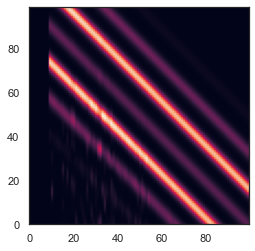

In [136]:
plt.imshow(P_pol_tpumpbig.T)
plt.ylim([0,99])

In [137]:
P_pol_tprobesmall = PhotocurrentArrayWKLinear_polarized(sigma=np.array([1,1j]/np.sqrt(2)),k_dir=1,k_other=0,k_bounds=[-0.1,0.1],wp_bounds=[-3,3],t0=0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe_small)


(0.0, 99.0)

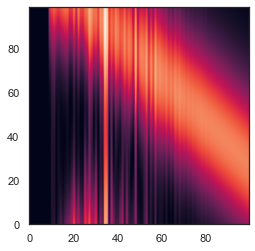

In [138]:
plt.imshow(P_pol_tprobesmall.T)
plt.ylim([0,99])

In [139]:
P_pol_tprobebig = PhotocurrentArrayWKLinear_polarized(sigma=np.array([1,1j]/np.sqrt(2)),k_dir=1,k_other=0,k_bounds=[-0.1,0.1],wp_bounds=[-3,3],t0=0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe_big)


(0.0, 99.0)

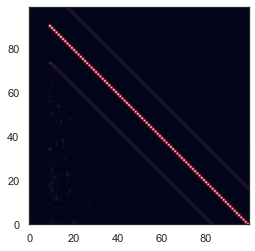

In [140]:
plt.imshow(P_pol_tprobebig.T)
plt.ylim([0,99])

In [141]:
# circular with different orientation x-iy instead of x+iy
P_pol_bis = fl.PhotocurrentArrayWKCircular_polarized(sigma=np.array([1,1j]/np.sqrt(2)),k_dir=1,k_other=0,k_bounds=[-0.1,0.1],wp_bounds=[-np.pi,np.pi],t0=0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)


(0.0, 99.0)

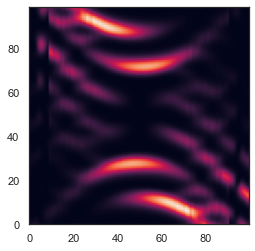

In [142]:
plt.imshow(P_pol_bis.T)
plt.ylim([0,99])

In [143]:
P_pol_tpumpsmall_bis = fl.PhotocurrentArrayWKCircular_polarized(sigma=np.array([1,1j]/np.sqrt(2)),k_dir=1,k_other=0,k_bounds=[-0.1,0.1],wp_bounds=[-np.pi,np.pi],t0=0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump_small,Tprobe=Tprobe)


(0.0, 99.0)

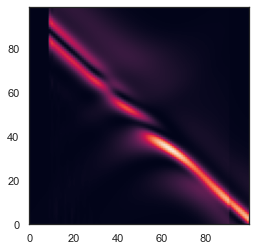

In [144]:
plt.imshow(P_pol_tpumpsmall_bis.T)
plt.ylim([0,99])

(0.0, 99.0)

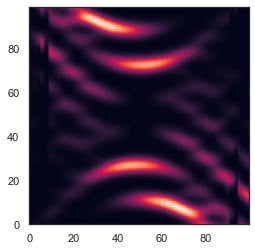

In [145]:
P_pol_tpumpbig_bis = fl.PhotocurrentArrayWKCircular_polarized(sigma=np.array([1,1j]/np.sqrt(2)),k_dir=1,k_other=0,k_bounds=[-0.1,0.1],wp_bounds=[-np.pi,np.pi],t0=0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump_big,Tprobe=Tprobe)
plt.imshow(P_pol_tpumpbig_bis.T)
plt.ylim([0,99])

(0.0, 99.0)

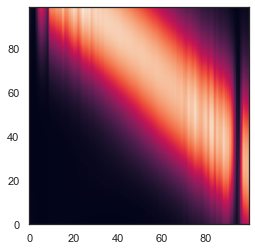

In [146]:
P_pol_tprobesmall_bis = fl.PhotocurrentArrayWKCircular_polarized(sigma=np.array([1,1j]/np.sqrt(2)),k_dir=1,k_other=0,k_bounds=[-0.1,0.1],wp_bounds=[-np.pi,np.pi],t0=0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe_small)
plt.imshow(P_pol_tprobesmall_bis.T)
plt.ylim([0,99])

(0.0, 99.0)

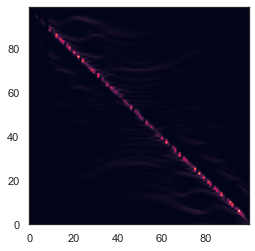

In [147]:
P_pol_tprobebig_bis = fl.PhotocurrentArrayWKCircular_polarized(sigma=np.array([1,1j]/np.sqrt(2)),k_dir=1,k_other=0,k_bounds=[-0.1,0.1],wp_bounds=[-np.pi,np.pi],t0=0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe_big)
plt.imshow(P_pol_tprobebig_bis.T)
plt.ylim([0,99])

# BiTe model

In [4]:
def Hbite(kx,ky,A2,D2):
    # diags
    H = D2*(kx**2+ky**2)*s0 + A2*(ky*s1 - kx*s2)
    
    return H

In [5]:
# function that diagonalizes Ephi=H0phi for IC of Dirac ODE
def InitialConditions_bite(kx,ky,A2,D2):
    """
    Returns phi and E for the time-independent Hamiltonian
    phi[:,alpha] is the alpha'th eigenvector
    """
    # initial Hamiltonian
    hk = Hbite(kx,ky,A2,D2)
    
    # diagonalize it
    E, phi = np.linalg.eigh(hk)
    
    return E, phi

In [69]:
# function f in dt{psi} = f(t,psi)
def bite_circular(t,psi,kx,ky,A2,D2,eE0,Omega,Tpump):
#     H = D2*(kx**2+ky**2)*s0 + A2*(ky*s1 - kx*s2)
#     kx_bump = -eE0/Omega * np.exp(-t**2/(2*Tpump**2)) * np.cos(Omega*t)
#     ky_bump = eE0/Omega * np.exp(-t**2/(2*Tpump**2)) * np.sin(Omega*t)
#     H = Hbite(kx+kx_bump,ky+ky_bump,A2,D2)
#     # TDSE d psi / dt = (below)
#     f = -1j/hbar * H @ psi
    
    # kinetic energy part
    kx_ = kx - eE0/Omega * np.exp(-t**2/(2*Tpump**2)) * np.cos(Omega*t) / hbar
    ky_ = ky + eE0/Omega * np.exp(-t**2/(2*Tpump**2)) * np.sin(Omega*t) / hbar
    H = D2*(kx_**2+ky_**2)*s0 + A2*(ky_*s1 - kx_*s2)
    # TDSE d psi / dt = (below)
    f = -1j/hbar * H @ psi
    return f

def PhotocurrentSA_bite(psi,s,kx,ky,w,t0,eE0,Omega,Tpump,Tprobe):
    # t-space
    t_space = psi.t
    # integrand: enveloppe * phase * psi
    integrand = Enveloppe(t_space,t0,Tprobe) * np.exp(1j*w*t_space) * psi.y[s,:]
    # integrate samples data using simpson's rule
    I = simpson(integrand,x=t_space)
    return np.abs(I)**2

def Photocurrent_bite(psi_0,psi_1,kx,ky,Es,w,t0,eE0,Omega,Tpump,Tprobe):
    """
    Main photocurrent function
    Es[i] corresponds to the energy of the minus (i=0) or plus (i=1) psi
    """
    # the phis are solved for in the main looping function (30/01/23 change)
    
    # integrate and add it up
    P = 0
    for s in range(2):
        # add up spins Fermi(Es[0],kT=0)
        P += PhotocurrentSA_bite(psi_0,s=s,kx=kx,ky=ky,w=w,t0=t0,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe) 
        P += PhotocurrentSA_bite(psi_1,s=s,kx=kx,ky=ky,w=w,t0=t0,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)
        
    return P

# function to help plotting and making arrays to visualize
def PhotocurrentArrayEnergyBiTe(res_w,wp_bounds,kx,ky,t0,A2,D2,eE0,Omega,Tpump,Tprobe):
    """
    Makes an array in w 
    """
    # set initial parameters
    ws = np.linspace(wp_bounds[0],wp_bounds[1],res_w)
    # note that the input bounds are on the normalized frequency wp = (w+wf)/Omega
    
    # diagonalize the time-independent system (at t-> -\infty)
    Es, phis = InitialConditions_bite(kx,ky,A2,D2)

    # solve the dirac equation
    psi_0 = solve_ivp(fun=bite_circular, t_span=[-600,500], y0=phis[:,0], args=(kx,ky,A2,D2,eE0,Omega,Tpump), method='RK45')
    psi_1 = solve_ivp(fun=bite_circular, t_span=[-600,500], y0=phis[:,1], args=(kx,ky,A2,D2,eE0,Omega,Tpump), method='RK45')

    P = np.zeros(res_w, dtype=float)
    for i,w in enumerate(ws):
        P[i] = Photocurrent_bite(psi_0=psi_0,psi_1=psi_1,Es=Es,kx=kx,ky=ky,w=w,t0=t0,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)
            
    return ws, P

In [70]:
ws,P=PhotocurrentArrayEnergyBiTe(res_w=100,wp_bounds=[-3,3],kx=0,ky=0,t0=-500,A2=3.33,D2=0,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)

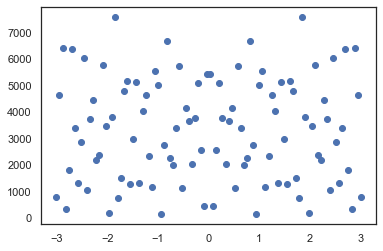

In [71]:
plt.scatter(ws,P)

In [201]:
def PhotocurrentArrayWKCircular_bite(k_dir,k_other,k_bounds,wp_bounds,t0,m,a,v,b,eE0,Omega,Tpump,Tprobe):
    """
    Makes an array in k-w plane 
    k_dir==1 for x and 2 for y
    k_other is the value of the remaining momentum
    """
    # set initial parameters
    res = 80 # takes ~30 seconds
    res_k = res
    res_w = res
    
    # make arrays
    ks = np.linspace(k_bounds[0],k_bounds[1],res_k)
    P = np.zeros((res_k,res_w), dtype=float)
    
    print("ready to loop")
    # loop over k
    if k_dir == 1:
        for i,kx in enumerate(ks):
            print("start loop")
            P[i,:] = PhotocurrentArrayEnergyBiTe(res_w=res_w,wp_bounds=wp_bounds,kx=kx,ky=k_other,t0=t0,m=m,a=a,v=v,b=b,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)[1] # second component is ps
            print("done loop {}".format(i))
    elif k_dir == 2:
        for i,ky in enumerate(ks):
            P[i,:] = PhotocurrentArrayEnergyBiTe(res_w=res_w,wp_bounds=wp_bounds,kx=k_other,ky=ky,t0=t0,m=m,a=a,v=v,b=b,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)[1] # second component is ps
        
    return P

In [204]:
P=PhotocurrentArrayWKCircular_bite(k_dir=1,k_other=0,k_bounds=[-1,1],wp_bounds=[-2,2],t0=0,m=0.2,a=4,v=1.5,b=8,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)

ready to loop
start loop
done loop 0
start loop
done loop 1
start loop
done loop 2
start loop
done loop 3
start loop
done loop 4
start loop
done loop 5
start loop
done loop 6
start loop
done loop 7
start loop
done loop 8
start loop
done loop 9
start loop
done loop 10
start loop
done loop 11
start loop
done loop 12
start loop
done loop 13
start loop
done loop 14
start loop
done loop 15
start loop
done loop 16
start loop
done loop 17
start loop
done loop 18
start loop
done loop 19
start loop
done loop 20
start loop
done loop 21
start loop
done loop 22
start loop
done loop 23
start loop
done loop 24
start loop
done loop 25
start loop
done loop 26
start loop
done loop 27
start loop
done loop 28
start loop
done loop 29
start loop
done loop 30
start loop
done loop 31
start loop
done loop 32
start loop
done loop 33
start loop
done loop 34
start loop
done loop 35
start loop
done loop 36
start loop
done loop 37
start loop
done loop 38
start loop
done loop 39
start loop
done loop 40
start loop
d

(0.0, 79.0)

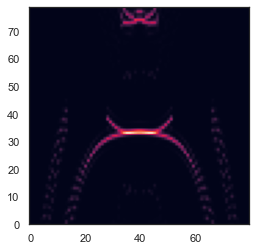

In [205]:
plt.imshow(P.T)
plt.ylim(0,79)

(0.0, 79.0)

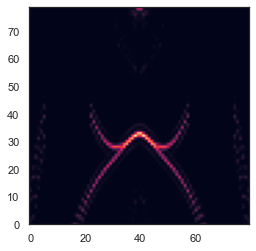

In [203]:
plt.imshow(P.T)
plt.ylim(0,79)

(0.0, 29.0)

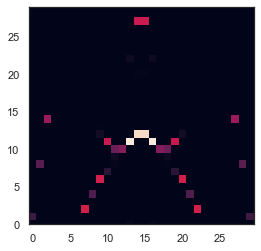

In [195]:
plt.imshow(P.T)
plt.ylim(0,29)

(0.0, 29.0)

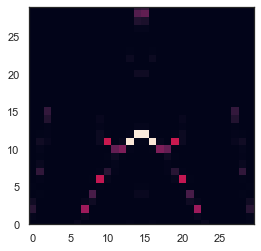

In [198]:
plt.imshow(P.T)
plt.ylim(0,29)

(0.0, 29.0)

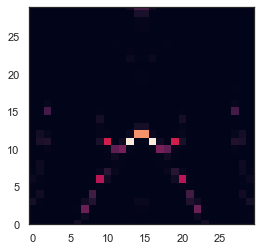

In [200]:
plt.imshow(P.T)
plt.ylim(0,29)